<a href="https://colab.research.google.com/github/marcinmichalsmolen/zum_nlp/blob/main/WUM5_Obraz_MarcinSmolen_s23429.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praca domowa - obraz


Najpierw upewnijmy się, że pracujemy na GPU. 

* Włącz GPU (Runtime / Change runtime type)

## MNIST



### Wczytanie i wizualizacja

* Wczytaj dane mnist do zmiennych X_train, y_train, X_test, y_test.
https://keras.io/datasets/

In [ ]:
from keras.datasets import mnist as dataset
import numpy as np
(X_train, y_train), (X_test, y_test) = dataset.load_data()

Teraz sprawdź i napisz:
* ile mamy instancji treningowych:
* ile mamy instancji testowych:
* jakie są wymiary w pixelach jednego obrazka:
* ile kanałów ma jeden obrazek:
* ile bajtów zajmuje jeden piksel:
* jaka jest minimalna i maksymalna wartość piksela:



In [ ]:
print("X_train: {}, y_train: {}", X_train.shape, y_train.shape)
print("X_test: {}, y_test: {}", X_test.shape, y_test.shape)

X_train: {}, y_train: {} (60000, 28, 28) (60000,)
X_test: {}, y_test: {} (10000, 28, 28) (10000,)



*   Instancji treningowych mamy 60000, 
*   testowych 10000, 
*   wymiary w pixelach: 28 x 28, 
*   jeden obrazek ma jeden kanał (odcienie szarości), 
*   1 piksel zajmuje 1 bajt czyli 2^8 ,
*   Minimalna wartość 0, maksymalna 255


Świetnie, teraz: 
* Wyrysuj pierwsze 12 elementów zbioru treningowego.
* Wypisz lub narysuj etykiety tych 12 elementów. 

[Tutaj są różne color mapy.](  
https://matplotlib.org/examples/color/colormaps_reference.html), których możesz użyć w funkcji imshow.  

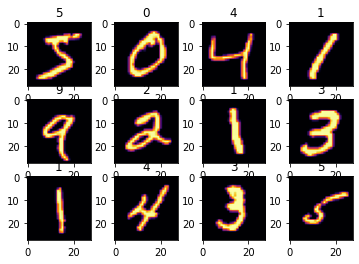

In [9]:
# Rysowanie 12 elementów - etykiety na górze
import matplotlib.pyplot as plt
plt.imshow(X_train[0], cmap='gray')
for i in range(12):
  plt.subplot(3, 4, i+1)
  plt.imshow(X_train[i], cmap='inferno')
  plt.title(y_train[i])
plt.show()

In [26]:
# Wypisanie samych 12 etykiet
for i in range(12):
 print(y_train[i])


5
0
4
1
9
2
1
3
1
4
3
5


* Teraz narysuj swój numer studenta używając cyfr zbioru mnist. Jeśli Twój indeks to np. s12345, wyrysuj 5 obrazków z cyframi '1', '2', '3', '4' i '5' obok siebie. 

### Klasyfikacja CNN'em

####Przygotowanie danych

Przygotujmy nasze dane treningowe:
* Przerób X_train i X_test tak, żeby wartości wszystkich pixeli były zawarte w przedziale <0,1>
* Zmień typ naszych pixeli na 'float32'

*Może się przydać metoda astype.*

In [45]:
X_train = X_train / 255
X_test = X_test / 255
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Przygotowaliśmy dane treningowe, teraz jeszcze etykiety.  W tej chwili jest to wektor liczb - dla każdej instancji mamy jedną liczbę. Nasza sieć będzie miała na wyjściu 10 wartości (wynik dla każdej klasy), więc musimy przerobić nasze liczby do postaci one-hot. Jeśli klasy trzech instancji to np. [0, 3, 5], w postaci one-hot będziemy mieć na przykład coś takiego:  
[1000000000]  
[0001000000]  
[0000010000]

Możesz do tego użyć funkcji [to_categorical](https://keras.io/api/utils/python_utils/).

* Przekonwertuj etykiety do postaci one-hot i wpisz wyniki do zmiennych Y_train i Y_test. 
* Wypisz 10 pierwszych elementów Y_train oraz y_train. 
* Napisz, jak w nowej postaci będą zapisane etykiety cyfr: 1, 2 i 4. 
* Wypisz kolejne cyfry swojego numeru indeksu używając powyższego zapisu. 

In [46]:
from keras.utils.np_utils import to_categorical as tk
Y_train = tk(y_train)
Y_test =tk(y_test)

In [47]:
for i in range(10):
 print([i], Y_train[i], y_train[i])

[0] [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 5
[1] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0
[2] [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 4
[3] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 1
[4] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 9
[5] [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] 2
[6] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 1
[7] [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] 3
[8] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 1
[9] [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 4



*   1 to [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.],
*   2 to [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.],
*   4 to [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


Pierwsze warstwy naszej sieci będą typu Conv2D. Przyjmują one dane instancji w postaci wielowymiarowych tablic. Nie spłaszczamy zatem danych do postaci wektora - jak musielibyśmy zrobić w przypatku SVM lub MLP. Zrobi to dopiero potem warstwa Flatten naszej sieci.  

Przekazujemy sieci instancje w postaci szerokość x wysokość x liczba_kanałów (format 'channels_last', w przypdku formatu 'channels_first' tablica miałaby wymiary liczba_kanałów x szerokość x wysokość).

* upewnij się, że działamy w trybie channels_last (keras.backend.image_data_format())
* sprawdź jeszcze raz shape danych treningowych i testowych
* jeśli brakuje nam ostatniego wymiaru, dodajmy go

*np.expand_dims(X_train, -1) powinien nam dodać brakujący wymiar na końcu; opcjonalnie można użyć kodu z ćwiczeń*

 

In [51]:
from keras import backend as K
print(K.image_data_format())
print("X_train: {}, y_train: {}", X_train.shape, y_train.shape)
print("X_test: {}, y_test: {}", X_test.shape, y_test.shape)

channels_last
X_train: {}, y_train: {} (60000, 28, 28) (60000,)
X_test: {}, y_test: {} (10000, 28, 28) (10000,)


#### Przygotowanie sieci

Prawdopodobnie przydadzą nam się poniższe importy. 
```python
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
```

In [79]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import tensorflow as tf
insh = (28, 28, 1)

* Zbuduj sieć z takimi warstwami:
 * Na wejściu [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/): 16 filtrów, kernel 3x3, padding 'same', activation [relu](https://cs-cheatsheet.readthedocs.io/en/latest/_images/activation_functions.png)
 * [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/): pool_size 2x2
 * Conv2D: 32 filtry, kernel 3x3, padding 'same', activation relu
 * MaxPooling2D: pool_size 2x2
 * [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/) (spłaszczamy dane do 1-wymiarowego wektora)
 * Na wyjściu [Dense](https://keras.io/api/layers/core_layers/dense/), units tyle, co klas, [aktywacja softmax](https://qph.fs.quoracdn.net/main-qimg-fda2f008df90ed5d7b6aff89b881e1ac)

Pierwsza warstwa będzie oczekiwać podania kształtu danych (input_shape). Czyli szerokość x wysokość x liczba kanałów. 

In [80]:
model = Sequential([
  Conv2D(16, kernel_size=(3,3), padding='same',activation='relu', input_shape = insh),
  MaxPooling2D(pool_size=(2,2)),
  Conv2D(32, kernel_size=(3,3), activation='relu'),
  MaxPooling2D(pool_size=(2,2)),
  Flatten(),
  Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

* Sprawdź, jak wygląda Twoja sieć  
Przyda się metoda model.summary i ewentualnie funkcja keras.utils.vis_utils.plot_model

In [81]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1152)              0         
                                                                 
 dense_4 (Dense)             (None, 10)               

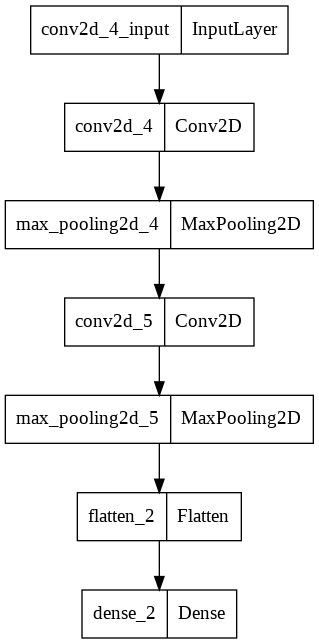

In [75]:
import tensorflow as tf
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)


* Spróbuj usunąć argument padding i napisz, co się zmieniło. 
* Przywróć padding. 

In [76]:
model = Sequential([
  Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=input_shape),
  MaxPooling2D(pool_size=(2,2)),
  Conv2D(32, kernel_size=(3,3), activation='relu'),
  MaxPooling2D(pool_size=(2,2)),
  Flatten(),
  Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [77]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 800)               0         
                                                                 
 dense_3 (Dense)             (None, 10)               

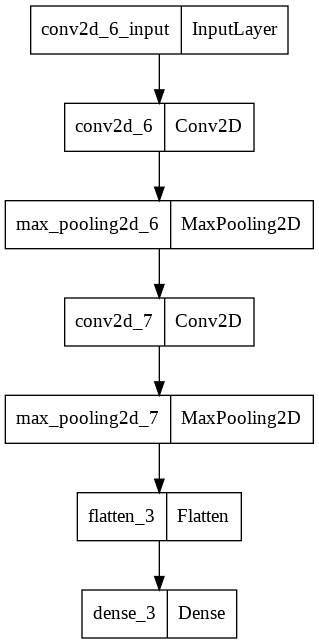

In [78]:
import tensorflow as tf
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)


Po usunięciu argumentu padding mamy mnie parametrów sieci

In [95]:
model = Sequential([
  Conv2D(16, kernel_size=(3,3), padding='same',activation='relu', input_shape = insh),
  MaxPooling2D(pool_size=(2,2)),
  Conv2D(32, kernel_size=(3,3), activation='relu'),
  MaxPooling2D(pool_size=(2,2)),
  Flatten(),
  Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Odpowiedz na poniższe pytania: 
* Czy warstwa Conv2D się uczy w trakcie treningu?: 
* Czy warstwa MaxPooling2D się uczy w trakcie treningu?:
* Dlaczego przed warstwą / warstwami Dense umieszczamy warstwę Flatten?:
* Ile będziemy mieć kanałów / map aktywacji po przepuszczeniu obrazka przez pierwszą warstwę Conv2D naszej sieci?:


Teraz:
* Uruchom metodę compile: loss 'categorical_crossentropy', optimizer 'adam'. Argument metrics przyjmuje tablicę stringów, możemy tam np. śledzić 'accuracy'. 

In [96]:
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [107]:
from matplotlib import pyplot
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [108]:
def summarize_diagnostics(history):
  pyplot.title('Dokładność klasyfikacji')
  pyplot.plot(history.history['accuracy'], color='orange', label='train')
  pyplot.subplots_adjust (right=2)
  pyplot.show()

#### Trening
* Wytrenuj sieć. 100 epok, batch_size 256.

Epoch 1/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1136 - accuracy: 0.9585
Epoch 2/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1090 - accuracy: 0.9605
Epoch 3/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1097 - accuracy: 0.9607
Epoch 4/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1095 - accuracy: 0.9610
Epoch 5/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1104 - accuracy: 0.9603
Epoch 6/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1101 - accuracy: 0.9601
Epoch 7/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1061 - accuracy: 0.9619
Epoch 8/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1069 - accuracy: 0.9619
Epoch 9/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1077 - accuracy: 0.9610
Epoch 10/100
235/235 [==============================] - 1s 5ms/step - loss: 0.1093 - accura

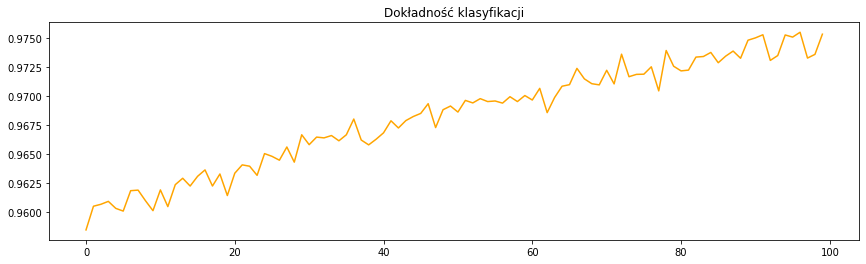

In [109]:
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=256,
    epochs=100,
    verbose="auto",
    callbacks=None,
    validation_split=0.0,
    )
summarize_diagnostics(history)



#### Ewaluacja
* Zrób ewaluację naszego modelu na zbiorze treningowym i testowym (metoda evaluate). 
* Podaj wyniki dla obu zbiorów: 
* Czy wyniki się różnią? Dlaczego? 

313/313 [==============================] - 1s 3ms/step - loss: 0.4859 - accuracy: 0.8991
Dokładności klasyfikacji na materiale treningowym  =  [0.05930555239319801, 0.9797833561897278]
dokładności klasyfikacji na materiale testowym  =  [0.48588475584983826, 0.8991000056266785]


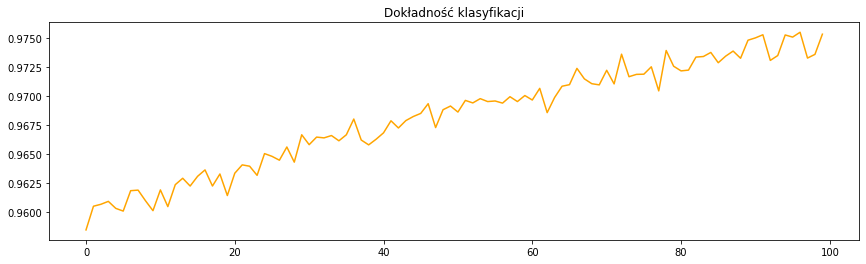

In [110]:
#model.evaluate(X_train, Y_train)
#model.evaluate(X_test, Y_test)
train_accuracy = model.evaluate(X_train, Y_train)
test_accuracy = model.evaluate(X_test, Y_test)
print('Dokładności klasyfikacji na materiale treningowym  = ',train_accuracy)
print('dokładności klasyfikacji na materiale testowym  = ',test_accuracy)

## FASHION MNIST 
Teraz powtórzymy eksperyment na innym, ale bardzo podobnym zbiorze danych. 

### Wczytanie i przygotowanie danych
* Wczytaj zbiór fashion_mnist analogicznie do mnist'a
* Przygotuj dane treningowe/testowe oraz etykiety analogicznie do mnista'a

In [100]:
from keras.datasets import fashion_mnist as dataset
import numpy as np
(X_train, y_train), (X_test, y_test) = dataset.load_data()
print("X_train: {}, y_train: {}", X_train.shape, y_train.shape)
print("X_test: {}, y_test: {}", X_test.shape, y_test.shape)

X_train: {}, y_train: {} (60000, 28, 28) (60000,)
X_test: {}, y_test: {} (10000, 28, 28) (10000,)


* Wyświetl 12 pierwszych instancji treningowych

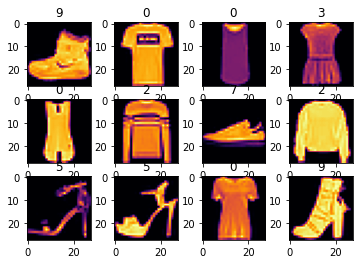

In [101]:
# Rysowanie 12 elementów - etykiety na górze
import matplotlib.pyplot as plt
plt.imshow(X_train[0], cmap='gray')
for i in range(12):
  plt.subplot(3, 4, i+1)
  plt.imshow(X_train[i], cmap='inferno')
  plt.title(y_train[i])
plt.show()

* Przygotuj dane i etykiety do treningu (tak samo jak w mnist)

In [102]:
X_train = X_train / 255
X_test = X_test / 255
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
from keras.utils.np_utils import to_categorical as tk
Y_train = tk(y_train)
Y_test =tk(y_test)

### Przygotowanie sieci i trening

* Stwórz identyczną sieć jak przy mnist i przeprowadź trening. 

In [103]:
model = Sequential([
  Conv2D(16, kernel_size=(3,3), padding='same',activation='relu', input_shape = insh),
  MaxPooling2D(pool_size=(2,2)),
  Conv2D(32, kernel_size=(3,3), activation='relu'),
  MaxPooling2D(pool_size=(2,2)),
  Flatten(),
  Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [104]:
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [105]:
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=256,
    epochs=100,
    verbose="auto",
    callbacks=None,
    validation_split=0.0,
    )
summarize_diagnostics(history)

Epoch 1/100
235/235 [==============================] - 2s 5ms/step - loss: 0.7444 - accuracy: 0.7398
Epoch 2/100
235/235 [==============================] - 1s 5ms/step - loss: 0.4374 - accuracy: 0.8469
Epoch 3/100
235/235 [==============================] - 1s 5ms/step - loss: 0.3915 - accuracy: 0.8627
Epoch 4/100
235/235 [==============================] - 1s 5ms/step - loss: 0.3613 - accuracy: 0.8729
Epoch 5/100
235/235 [==============================] - 1s 5ms/step - loss: 0.3391 - accuracy: 0.8811
Epoch 6/100
235/235 [==============================] - 1s 5ms/step - loss: 0.3264 - accuracy: 0.8848
Epoch 7/100
235/235 [==============================] - 1s 5ms/step - loss: 0.3118 - accuracy: 0.8900
Epoch 8/100
235/235 [==============================] - 1s 5ms/step - loss: 0.3016 - accuracy: 0.8929
Epoch 9/100
235/235 [==============================] - 1s 5ms/step - loss: 0.2939 - accuracy: 0.8957
Epoch 10/100
235/235 [==============================] - 1s 5ms/step - loss: 0.2837 - accura

### Ewaluacja
* Zrób ewaluację naszego modelu na zbiorze treningowym i testowym (metoda evaluate).
* Podaj wyniki dla obu zbiorów:

In [111]:
train_accuracy = model.evaluate(X_train, Y_train)
test_accuracy = model.evaluate(X_test, Y_test)
print('Dokładności klasyfikacji na materiale treningowym  = ',train_accuracy)
print('dokładności klasyfikacji na materiale testowym  = ',test_accuracy)


313/313 [==============================] - 1s 3ms/step - loss: 0.4859 - accuracy: 0.8991
Dokładności klasyfikacji na materiale treningowym  =  [0.05930555239319801, 0.9797833561897278]
dokładności klasyfikacji na materiale testowym  =  [0.48588475584983826, 0.8991000056266785]


### Early stopping
* Dodajmy do treningu zbiór walidacyjny - możesz do tego użyć argumentu 'validation_split' metody [fit](https://keras.io/api/models/model_training_apis/). Zróbmy 10%. 
* Dodaj [early stopping](https://keras.io/api/callbacks/early_stopping/), patience 5. 
* Przeprowadź dwa treningi - najpierw monitorując w early stopping 'loss' a potem 'val_loss'. Jaka jest różnica? 

Jeśli early stopping nie miał okazji zadziałać, zwiększ liczbę epok. 

In [119]:
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from matplotlib import pyplot

In [120]:
f1 = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=0, patience=5, mode="auto")
f2 = tf.keras.callbacks.ModelCheckpoint(filepath='modelx', save_weights_only = False, monitor = 'accuracy', mode='max', save_best_only = True)
f3 = tf.keras.callbacks.TensorBoard(log_dir='./logs')

Epoch 1/100
211/211 [==============================] - 1s 6ms/step - loss: 0.0467 - accuracy: 0.9832 - val_loss: 0.2115 - val_accuracy: 0.9403
Epoch 2/100
211/211 [==============================] - 1s 5ms/step - loss: 0.0449 - accuracy: 0.9844 - val_loss: 0.2123 - val_accuracy: 0.9388
Epoch 3/100
211/211 [==============================] - 1s 6ms/step - loss: 0.0465 - accuracy: 0.9832 - val_loss: 0.2317 - val_accuracy: 0.9365
Epoch 4/100
211/211 [==============================] - 1s 6ms/step - loss: 0.0465 - accuracy: 0.9834 - val_loss: 0.2079 - val_accuracy: 0.9387
Epoch 5/100
211/211 [==============================] - 1s 6ms/step - loss: 0.0436 - accuracy: 0.9846 - val_loss: 0.2218 - val_accuracy: 0.9368
Epoch 6/100
211/211 [==============================] - 1s 5ms/step - loss: 0.0434 - accuracy: 0.9851 - val_loss: 0.2508 - val_accuracy: 0.9293
Epoch 7/100
211/211 [==============================] - 1s 6ms/step - loss: 0.0458 - accuracy: 0.9835 - val_loss: 0.2200 - val_accuracy: 0.9377

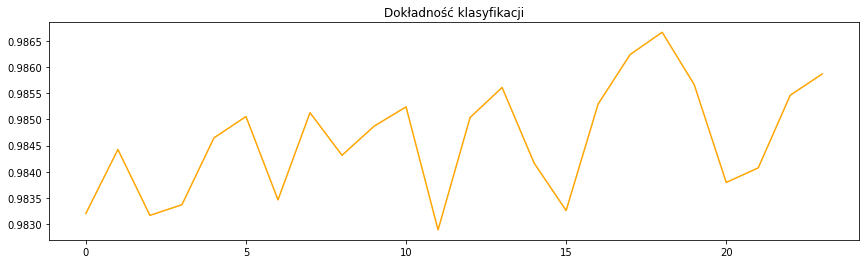

In [122]:
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=256,
    epochs=100,
    verbose="auto",
    callbacks= [f1,f2,f3],
    validation_split=0.1,
    )
trained_model = keras.models.load_model('modelx')
train_accuracy = trained_model.evaluate(X_train, Y_train)
test_accuracy = trained_model.evaluate(X_test, Y_test)
print(train_accuracy + test_accuracy)
print('Dokładności klasyfikacji na materiale treningowym  = ',train_accuracy)
print('dokładności klasyfikacji na materiale testowym  = ',test_accuracy)
summarize_diagnostics(history)

### Poprawa wyniku
* Spróbuj stworzyć 3 sieci, które uzyskają lepszy wynik na zbiorze fashion_mnist. Możesz zmodyfikować naszą prostą sieć lub zaprojektować zupełnie nową. 
* Poeksperymentuj z modyfikacjami warstw Conv2D (np. zmiana liczby filtrów), dodawaniem warstw Conv2D i Dense. Możesz też dodać Dropout. 
* Dla każdej z tych sieci przeprowadź ewaluację i wypisz wyniki. 

To wszystko. Dziękuję! 